# Theory

## Gradient Descent (GD)

## Batch Gradient Descent (BGD)

## Stochastic Gradient Descent (SGD)

## Mini-batch Gradient Descent (Mini-batch GD)

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data preparation

In [ ]:
rng = np.random.default_rng(42)  # Para eventos reproducibles
m = 100  # Number of instances
X = 2 * rng.random((m, 1))
y = 4 + 3 * X + rng.random((m, 1))  # Generamos y = b + m * x: b = 4, m = 3

In [17]:
print("X", X.shape)
print("y", y.shape)

X (100, 1)
y (100, 1)


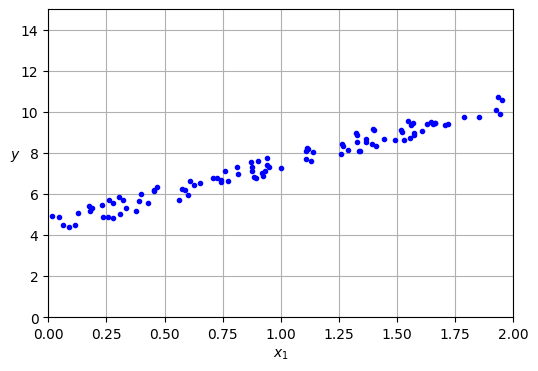

In [18]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [ ]:
from sklearn.preprocessing import add_dummy_feature  # Augment dataset with an additional dummy feature.

X_b = add_dummy_feature(X)  # Using a dummy variable to simulate theta_0 = 1
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y  # @ se usa en lugar de np.dot()
print("Theta optimiced: ", theta_best)


Theta optimiced:  [[4.57201738]
 [2.92706591]]


In [ ]:
# Usamos y = X * theta_best 
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
print("X_new", X_new_b)
print("y_pred", y_predict)

X_new [[1. 0.]
 [1. 2.]]
y_pred [[ 4.57201738]
 [10.42614921]]


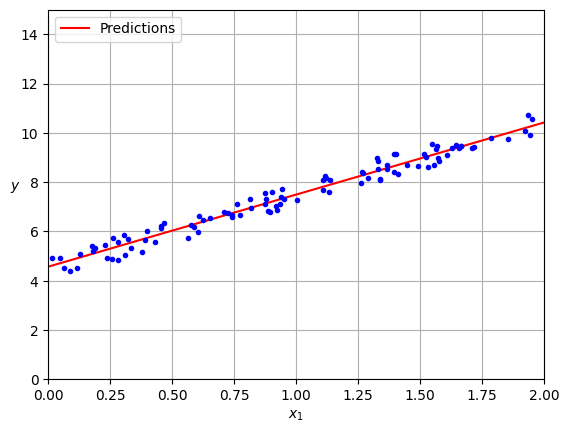

In [ ]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

In [ ]:
# Using the linear regression model from sklearn
from sklearn.linear_model import LinearRegression

LR = LinearRegression()
LR.fit(X, y)
print("Intercept: ", LR.intercept_, "Slope: ", LR.coef_)  # Coincides with the line simulated

Intercept:  [4.57201738] Slope:  [[2.92706591]]


## Implementation

In [45]:
import time

### BGD

In [52]:
eta = 0.1  # Learning rate
n_epoch = 1000 # Total of iterations
m = len(X_b)  # Number of instances

theta = rng.random((2, 1))  # Randomly initialized model params

start = time.time()
for epoch in range(n_epoch): 
    gradients = 2 / m * X_b.T @(X_b @theta - y)  # Derivative of the empirical risk over the param 
    theta = theta -eta * gradients
bgd_end = time.time() - start

bgd_theta = theta
print("BGD params: ", bgd_theta)

print("Runing time: ", bgd_end)

BGD params:  [[4.57201738]
 [2.92706591]]
Runing time:  0.014092206954956055


### SGD

### Mini-batch GD

## Results

## Conclusion